In [1]:
import sys
sys.argv.append("-lc=C:/Workspaces/AIC/simod/local_config_files/fido-PC.cfg")

In [2]:
from simod.init import config

INFO:root:Loading config for project RoadmaptoolsConfig (can be overwritten later)
INFO:root:map_dir: C:/AIC Experiment Data/VGA/maps/
osm_source_url: https://s3.amazonaws.com/metro-extracts.mapzen.com/valencia_spain.osm.bz2
osm_map_filename: C:/AIC Experiment Data/VGA/maps/map.osm
filtered_osm_filename: C:/AIC Experiment Data/VGA/maps/map-filtered.osm
geojson_file: C:/AIC Experiment Data/VGA/maps/map.geojson
cleaned_geojson_file: C:/AIC Experiment Data/VGA/maps/map-cleaned.geojson
sanitized_geojson_file: C:/AIC Experiment Data/VGA/maps/map-sanitized.geojson
simplified_file: C:/AIC Experiment Data/VGA/maps/map-simplified.geojson
simplified_file_with_speed: C:/AIC Experiment Data/VGA/maps/map-simplified-speed.geojson
simplified_file_with_speed_and_curvature: C:/AIC Experiment Data/VGA/maps/map-simplified-speed-curvature.geojson
ap_nodes_file: C:/AIC Experiment Data/VGA/maps/nodes.geojson
ap_edges_file: C:/AIC Experiment Data/VGA/maps/edges.geojson
utm_center_lon: 50.0877506
utm_center_l

In [20]:
from typing import List, Tuple, Dict
import roadmaptools.inout
import simod.statistics.model.edges as edges
import simod.statistics.model.transit as transit
import simod.statistics.model.ridesharing as ridesharing
import simod.statistics.model.service as service
import simod.statistics.comparisons.common as common
import matplotlib.pyplot as plt
from itertools import islice
import importlib
import os.path

In [12]:
peak_experiments = {
    'delay_experiments': [
        ["vga-max_delay_3_min", "vga"],
        ["vga-lim-max_delay_3_min", "vga-lim", "vga-lim-max_delay_5_min", "vga-lim-max_delay_6_min", "vga-lim-max_delay_7_min"],
        ["vga-pnas-max_delay_3_min", "vga-pnas", "vga-pnas-max_delay_5_min", "vga-pnas-max_delay_6_min", "vga-pnas-max_delay_7_min"]
    ],
    'batch_experiments': [
        ["vga"],
        ["vga-lim", "vga-lim-batch_60s", "vga-lim-batch_90s", "vga-lim-batch_120s"],
        ["vga-pnas", "vga-pnas-batch_60s", "vga-pnas-batch_90s", "vga-pnas-batch_120s"]
    ],
    'capacity_experiments':[
        ['vga-capacity_2', "vga"],
        ['vga-lim-capacity_2', "vga-lim", 'vga-lim-capacity_10'],
        ['vga-pnas-capacity_2', "vga-pnas", 'vga-pnas-capacity_10']
    ]
}

off_peak_experiments = {
    'delay_experiments': [
        ["sw-vga-max_delay_3_min", "sw-vga", "sw-vga-max_delay_5_min", "sw-vga-max_delay_6_min"],
        ["sw-vga-lim-max_delay_3_min", "sw-vga-lim", "sw-vga-lim-max_delay_5_min", "sw-vga-lim-max_delay_6_min", "sw-vga-lim-max_delay_7_min"],
        ["sw-vga-pnas-max_delay_3_min", "sw-vga-pnas", "sw-vga-pnas-max_delay_5_min", "sw-vga-pnas-max_delay_6_min", "sw-vga-pnas-max_delay_7_min"]
    ],
    'batch_experiments': [
        ["sw-vga", "sw-vga-batch_60s", "sw-vga-batch_90s", "sw-vga-batch_120s"],
        ["sw-vga-lim", "sw-vga-lim-batch_60s", "sw-vga-lim-batch_90s", "sw-vga-lim-batch_120s"],
        ["sw-vga-pnas", "sw-vga-pnas-batch_60s", "sw-vga-pnas-batch_90s", "sw-vga-pnas-batch_120s"]
    ],
    'capacity_experiments':[
        ['sw-vga-capacity_2', "sw-sw-vga", 'sw-vga-capacity_10'],
        ['sw-vga-lim-capacity_2', "sw-vga-lim", 'sw-vga-lim-capacity_10'],
        ['sw-vga-pnas-capacity_2', "sw-vga-pnas", 'sw-vga-pnas-capacity_10']
    ]
}

manhattan_experiments = {
    'delay_experiments': [
        ["sw-vga-max_delay_3_min", "sw-vga", "sw-vga-max_delay_5_min", "sw-vga-max_delay_6_min"],
        ["sw-vga-lim-max_delay_3_min", "sw-vga-lim", "sw-vga-lim-max_delay_5_min", "sw-vga-lim-max_delay_6_min", "sw-vga-lim-max_delay_7_min"],
        ["sw-vga-pnas-max_delay_3_min", "sw-vga-pnas", "sw-vga-pnas-max_delay_5_min", "sw-vga-pnas-max_delay_6_min", "sw-vga-pnas-max_delay_7_min"]
    ],
    'batch_experiments': [
        ["sw-vga", "sw-vga-batch_60s", "sw-vga-batch_90s", "sw-vga-batch_120s"],
        ["sw-vga-lim", "sw-vga-lim-batch_60s", "sw-vga-lim-batch_90s", "sw-vga-lim-batch_120s"],
        ["sw-vga-pnas", "sw-vga-pnas-batch_60s", "sw-vga-pnas-batch_90s", "sw-vga-pnas-batch_120s"]
    ],
    'capacity_experiments':[
        ['sw-vga-capacity_2', "sw-sw-vga", 'sw-vga-capacity_10'],
        ['sw-vga-lim-capacity_2', "sw-vga-lim", 'sw-vga-lim-capacity_10'],
        ['sw-vga-pnas-capacity_2', "sw-vga-pnas", 'sw-vga-pnas-capacity_10']
    ]
}
for exp_set in manhattan_experiments.values():
    for index, method in enumerate(exp_set):
        new_list =  [f"Manhattan/{name}" for name in method]
        exp_set[index] = new_list

In [13]:
manhattan_experiments

{'delay_experiments': [['Manhattan/sw-vga-max_delay_3_min',
   'Manhattan/sw-vga',
   'Manhattan/sw-vga-max_delay_5_min',
   'Manhattan/sw-vga-max_delay_6_min'],
  ['Manhattan/sw-vga-lim-max_delay_3_min',
   'Manhattan/sw-vga-lim',
   'Manhattan/sw-vga-lim-max_delay_5_min',
   'Manhattan/sw-vga-lim-max_delay_6_min',
   'Manhattan/sw-vga-lim-max_delay_7_min'],
  ['Manhattan/sw-vga-pnas-max_delay_3_min',
   'Manhattan/sw-vga-pnas',
   'Manhattan/sw-vga-pnas-max_delay_5_min',
   'Manhattan/sw-vga-pnas-max_delay_6_min',
   'Manhattan/sw-vga-pnas-max_delay_7_min']],
 'batch_experiments': [['Manhattan/sw-vga',
   'Manhattan/sw-vga-batch_60s',
   'Manhattan/sw-vga-batch_90s',
   'Manhattan/sw-vga-batch_120s'],
  ['Manhattan/sw-vga-lim',
   'Manhattan/sw-vga-lim-batch_60s',
   'Manhattan/sw-vga-lim-batch_90s',
   'Manhattan/sw-vga-lim-batch_120s'],
  ['Manhattan/sw-vga-pnas',
   'Manhattan/sw-vga-pnas-batch_60s',
   'Manhattan/sw-vga-pnas-batch_90s',
   'Manhattan/sw-vga-pnas-batch_120s']],
 '

In [14]:
loaded_edges = roadmaptools.inout.load_geojson(config.agentpolis.map_edges_filepath)
edge_data = edges.make_data_frame(loaded_edges)

[15:28:34]: Loading geojson file from: C:\AIC Experiment Data\VGA\maps\edges.geojson


In [15]:
def load_experiment_data(experiment_name: str):
    
    # distance
    experiment_dir = "{}/{}/".format(config.experiments_dir, experiment_name)
    transit_data = transit.load(experiment_dir)
    km_total_window = int(round(transit.get_total_distance(transit_data, edge_data, True) / 1000 / 100))
    
    # time
    performance_data = ridesharing.load(experiment_dir)
    avg_time = performance_data['Group Generation Time'].mean() + performance_data['Solver Time'].mean()
    # avg_time = int(round(avg_time / 1000))
    avg_time = int(round(avg_time))
    
    # delay
    service_stat = service.load_dataframe(experiment_dir)
    delays_window = service.get_delays(service_stat, True, False)
    mean_delay = int(round(delays_window.mean() / 1000))
    
    return km_total_window, avg_time, mean_delay    

In [27]:
x_values_delay = [3, 4, 5, 6, 7]
x_values_batch = [30, 60, 90, 120]
x_values_capacity = [2, 5, 10]

x_values = [x_values_delay, x_values_batch, x_values_capacity]

In [18]:
def check_experiments(experiments: Dict[str, List[List[str]]]):
    for experiment_set in experiments.values():
        for method in experiment_set:
            for exp_name in method:
                experiment_dir = "{}/{}/".format(config.experiments_dir, exp_name)
                if not os.path.exists(experiment_dir):
                    raise Exception(f"experiment {experiment_dir} not found")


def load_experiments(experiments: Dict[str, List[List[str]]]):
    speed_data = []
    tt_data = []
    delay_data = []
    
    for experiment_set in experiments.values():
        for method in experiment_set:
            for exp_name in method:
                record = load_experiment_data(exp_name)
                speed_data.append(record[0])
                tt_data.append(record[1])
                delay_data.append(record[2])
                
    speed_data = [rec / 1000 for rec in speed_data]
    tt_data = [rec / 1000 for rec in tt_data]
    
    return speed_data, tt_data, delay_data

In [21]:
check_experiments(peak_experiments)
speed_data, tt_data, delay_data = load_experiments(peak_experiments)

[15:33:35]: Loading csv file from: C:\AIC Experiment Data\VGA\experiments\vga-max_delay_3_min\ridesharing.csv to dataframe
[15:33:38]: Loading csv file from: C:\AIC Experiment Data\VGA\experiments\vga\ridesharing.csv to dataframe
[15:33:42]: Loading csv file from: C:\AIC Experiment Data\VGA\experiments\vga-lim-max_delay_3_min\ridesharing.csv to dataframe
[15:33:45]: Loading csv file from: C:\AIC Experiment Data\VGA\experiments\vga-lim\ridesharing.csv to dataframe
[15:33:49]: Loading csv file from: C:\AIC Experiment Data\VGA\experiments\vga-lim-max_delay_5_min\ridesharing.csv to dataframe
[15:33:52]: Loading csv file from: C:\AIC Experiment Data\VGA\experiments\vga-lim-max_delay_6_min\ridesharing.csv to dataframe
[15:33:56]: Loading csv file from: C:\AIC Experiment Data\VGA\experiments\vga-lim-max_delay_7_min\ridesharing.csv to dataframe
[15:34:00]: Loading csv file from: C:\AIC Experiment Data\VGA\experiments\vga-pnas-max_delay_3_min\ridesharing.csv to dataframe
[15:34:04]: Loading csv

In [22]:
def plot_ax(xvalues, data: List[float], axis, experiment: common.Experiment):
    axis.plot(xvalues, data, marker=experiment.marker, linestyle='dashed', color=experiment.color, label=experiment.label)

In [30]:
def plot_sensitivity_analysis(experiments: Dict[str, List[List[str]]], speed_data, tt_data, delay_data):
    fig, axes = plt.subplots(3, 3, sharex='col')
    axes[0][0].set_ylabel("Avg. comp. \n time [s]")
    axes[1][0].set_ylabel("Total Distance \n" r"[km $\cdot 10^3$]")
    axes[2][0].set_ylabel("Avg. delay [s]")
    axes[2][0].set_xlabel(r"Batch length [s]")
    axes[2][0].set_xticks(x_values_batch)
    axes[2][1].set_xlabel(r"Max delay [min]")
    axes[2][1].set_xticks(x_values_delay)
    axes[2][2].set_xlabel(r"Capacity")
    axes[2][2].set_xticks(x_values_capacity)

    to_index = 0
    from_index = 0
    for experiment_set, axis_index in zip(experiments.values(), [1, 0, 2]):
        x_values_l = x_values[axis_index]
        for method, experiment in zip(experiment_set, islice(common.Experiment, 3, 6)):
            to_index += len(method)
            
            plot_ax(x_values_l[:len(method)], tt_data[from_index:to_index], axes[0][axis_index], experiment)
            plot_ax(x_values_l[:len(method)], speed_data[from_index:to_index], axes[1][axis_index], experiment)
            plot_ax(x_values_l[:len(method)], delay_data[from_index:to_index], axes[2][axis_index], experiment)

            from_index = to_index
    
    axes[0][0].legend(loc=1, fontsize='small', borderaxespad=0.2)
    plt.savefig(config.images.sensitivity_analysis, bbox_inches='tight', transparent=True, pad_inches=0.0, dpi=fig.dpi)

ValueError: x and y must have same first dimension, but have shapes (4,) and (5,)

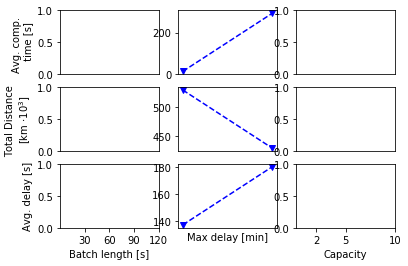

In [31]:
plot_sensitivity_analysis(peak_experiments, speed_data, tt_data, delay_data)

In [31]:
offpeak_speed_data, offpeak_tt_data, offpeak_delay_data = load_experiments(off_peak_experiments)

[10:35:52]: Loading csv file from: C:\AIC Experiment Data\VGA\experiments\sw-vga-max_delay_3_min\ridesharing.csv to dataframe
[10:35:54]: Loading csv file from: C:\AIC Experiment Data\VGA\experiments\sw-vga\ridesharing.csv to dataframe
[10:35:56]: Loading csv file from: C:\AIC Experiment Data\VGA\experiments\sw-vga-max_delay_5_min\ridesharing.csv to dataframe
[10:35:57]: Loading csv file from: C:\AIC Experiment Data\VGA\experiments\sw-vga-max_delay_6_min\ridesharing.csv to dataframe
[10:35:59]: Loading csv file from: C:\AIC Experiment Data\VGA\experiments\sw-vga-lim_gap_005_gg_60ms-max_delay_3_min\ridesharing.csv to dataframe
[10:36:01]: Loading csv file from: C:\AIC Experiment Data\VGA\experiments\sw-vga-lim_gap_005_gg_60ms\ridesharing.csv to dataframe
[10:36:03]: Loading csv file from: C:\AIC Experiment Data\VGA\experiments\sw-vga-lim_gap_005_gg_60ms-max_delay_5_min\ridesharing.csv to dataframe
[10:36:04]: Loading csv file from: C:\AIC Experiment Data\VGA\experiments\sw-vga-lim_gap_0

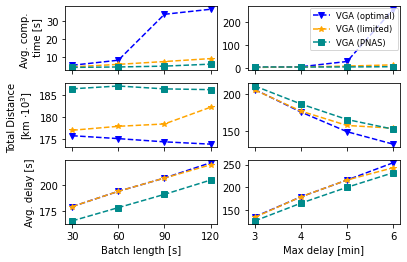

In [35]:
plot_sensitivity_analysis(off_peak_experiments, offpeak_speed_data, offpeak_tt_data, offpeak_delay_data)

In [22]:
import amodsim.statistics.comparisons
importlib.reload(amodsim.statistics.comparisons.common)

<module 'amodsim.statistics.comparisons.common' from 'c:\\workspaces\\aic\\simod\\python\\amodsim\\statistics\\comparisons\\common.py'>

In [27]:
for en in islice(common.Experiment, 3, 6):
    print(en.label)

VGA (optimal)
VGA (limited)
VGA (PNAS)


In [ ]:
plot_ax(x_values_batch, speed_data[4:], axes[0][0])
    plot_ax(x_values_delay, speed_data[:4], axes[0][1])
    plot_ax(x_values_batch, tt_data[4:], axes[1][0])
    plot_ax(x_values_delay, tt_data[:4], axes[1][1])
    plot_ax(, delay_data[4:], axes[2][0])
    plot_ax(x_values_delay, delay_data[:4], axes[2][1])

In [ ]:
    for exp_name in batch_experiments:
        record = load_experiment_data(exp_name)
        speed_data.append(record[0])
        tt_data.append(record[1])
        delay_data.append(record[2])

Text(0.5, 0, 'Max delay [min]')

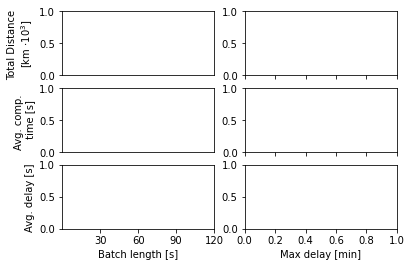

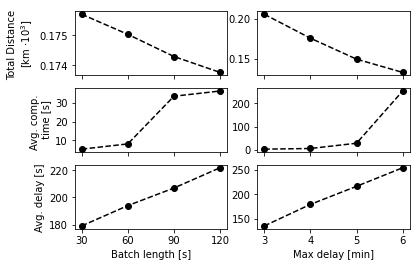

In [108]:
fig

In [49]:
plot_ax(batch_exp_data, 0, x_values_batch, axes[0][0])
plot_ax(batch_exp_data, 1, x_values_batch, axes[1][0])
plot_ax(batch_exp_data, 2, x_values_batch, axes[2][0])
plot_ax(delay_exp_data, 0, x_values_delay, axes[0][1])
plot_ax(delay_exp_data, 1, x_values_delay, axes[1][1])
plot_ax(delay_exp_data, 2, x_values_delay, axes[2][1])

In [ ]:
axes[0][0].plot(x_values_batch, speed_data[4:])
axes[0][1].plot(x_values_delay, speed_data[:4])
axes[1][0].plot(x_values_batch, tt_data[4:])
axes[1][1].plot(x_values_delay, tt_data[:4])
axes[2][0].plot(x_values_batch, delay_data[4:])
axes[2][1].plot(x_values_delay, delay_data[:4])

In [ ]:
peak_experiments = {
    'delay_experiments': [
        ["vga-max_delay_3_min", "vga"],
        ["vga-lim_gap_005_gg_60ms-max_delay_3_min", "vga-lim_gap_005_gg_60ms", "vga-lim_gap_005_gg_60ms-max_delay_5_min", "vga-lim_gap_005_gg_60ms-max_delay_6_min"],
        ["vga-pnas-max_delay_3_min", "vga-pnas", "vga-pnas-max_delay_5_min", "vga-pnas-max_delay_6_min"]
    ],
    'batch_experiments': [
        ["vga"],
        ["vga-lim_gap_005_gg_60ms", "vga-lim_gap_005_gg_60ms-batch_60s", "vga-lim_gap_005_gg_60ms-batch_90s", "vga-lim_gap_005_gg_60ms-batch_120s"],
        ["vga-pnas", "vga-pnas-batch_60s", "vga-pnas-batch_90s", "vga-pnas-batch_120s"]
    ]
}

off_peak_experiments = {
    'delay_experiments': [
        ["sw-vga-max_delay_3_min", "sw-vga", "sw-vga-max_delay_5_min", "sw-vga-max_delay_6_min"],
        ["sw-vga-lim_gap_005_gg_60ms-max_delay_3_min", "sw-vga-lim_gap_005_gg_60ms", "sw-vga-lim_gap_005_gg_60ms-max_delay_5_min", "sw-vga-lim_gap_005_gg_60ms-max_delay_6_min"],
        ["sw-vga-pnas-max_delay_3_min", "sw-vga-pnas", "sw-vga-pnas-max_delay_5_min", "sw-vga-pnas-max_delay_6_min"]
    ],
    'batch_experiments': [
        ["sw-vga", "sw-vga-batch_60s", "sw-vga-batch_90s", "sw-vga-batch_120s"],
        ["sw-vga-lim_gap_005_gg_60ms", "sw-vga-lim_gap_005_gg_60ms-batch_60s", "sw-vga-lim_gap_005_gg_60ms-batch_90s", "sw-vga-lim_gap_005_gg_60ms-batch_120s"],
        ["sw-vga-pnas", "sw-vga-pnas-batch_60s", "sw-vga-pnas-batch_90s", "sw-vga-pnas-batch_120s"]
    ]
}
